
<center><h1>Data Management Project - NOAA Weather Impact</h1></center>
The purpose of this project is to create a database to help analysts understand the effects of weather on bike rentals. This step represents the "T" in the "ETL" process, where the data is cleaned, transformed, and exported to the repository for loading.

In [1]:
# Data
import pandas as pd
import numpy as np
import math
import glob 
import re
from collections import Counter
import missingno as msno

In [2]:
# Imports all datasets that start with JC-20160 and end with -citibike-tripdata.csv, where * is a wildcard
trips = glob.glob('data\\JC-20160*-citibike-tripdata.csv') 

# Initialize an empty list to store the dataframes created from each CSV file
trips_list = []

# Parse each csv file and transform them into dataframes to append to df list
for trip in trips: 
    data = pd.read_csv(trip)
    trips_list.append(data)

trips = pd.concat(trips_list)
trips.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0


In [3]:
NOAA = pd.read_csv('data\\newark_airport_2016.csv')
NOAA.head()

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
0,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-01,12.75,NaN,0.0,0.0,0.0,41,43,34,NaN,270,280.0,25.9,35.1
1,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-02,9.40,NaN,0.0,0.0,0.0,36,42,30,NaN,260,260.0,21.0,25.1
2,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-03,10.29,NaN,0.0,0.0,0.0,37,47,28,NaN,270,250.0,23.9,30.0
3,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-04,17.22,NaN,0.0,0.0,0.0,32,35,14,NaN,330,330.0,25.9,33.1
4,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-05,9.84,NaN,0.0,0.0,0.0,19,31,10,NaN,360,350.0,25.1,31.1


## Handling Missing Data

#### Trips

<Axes: >

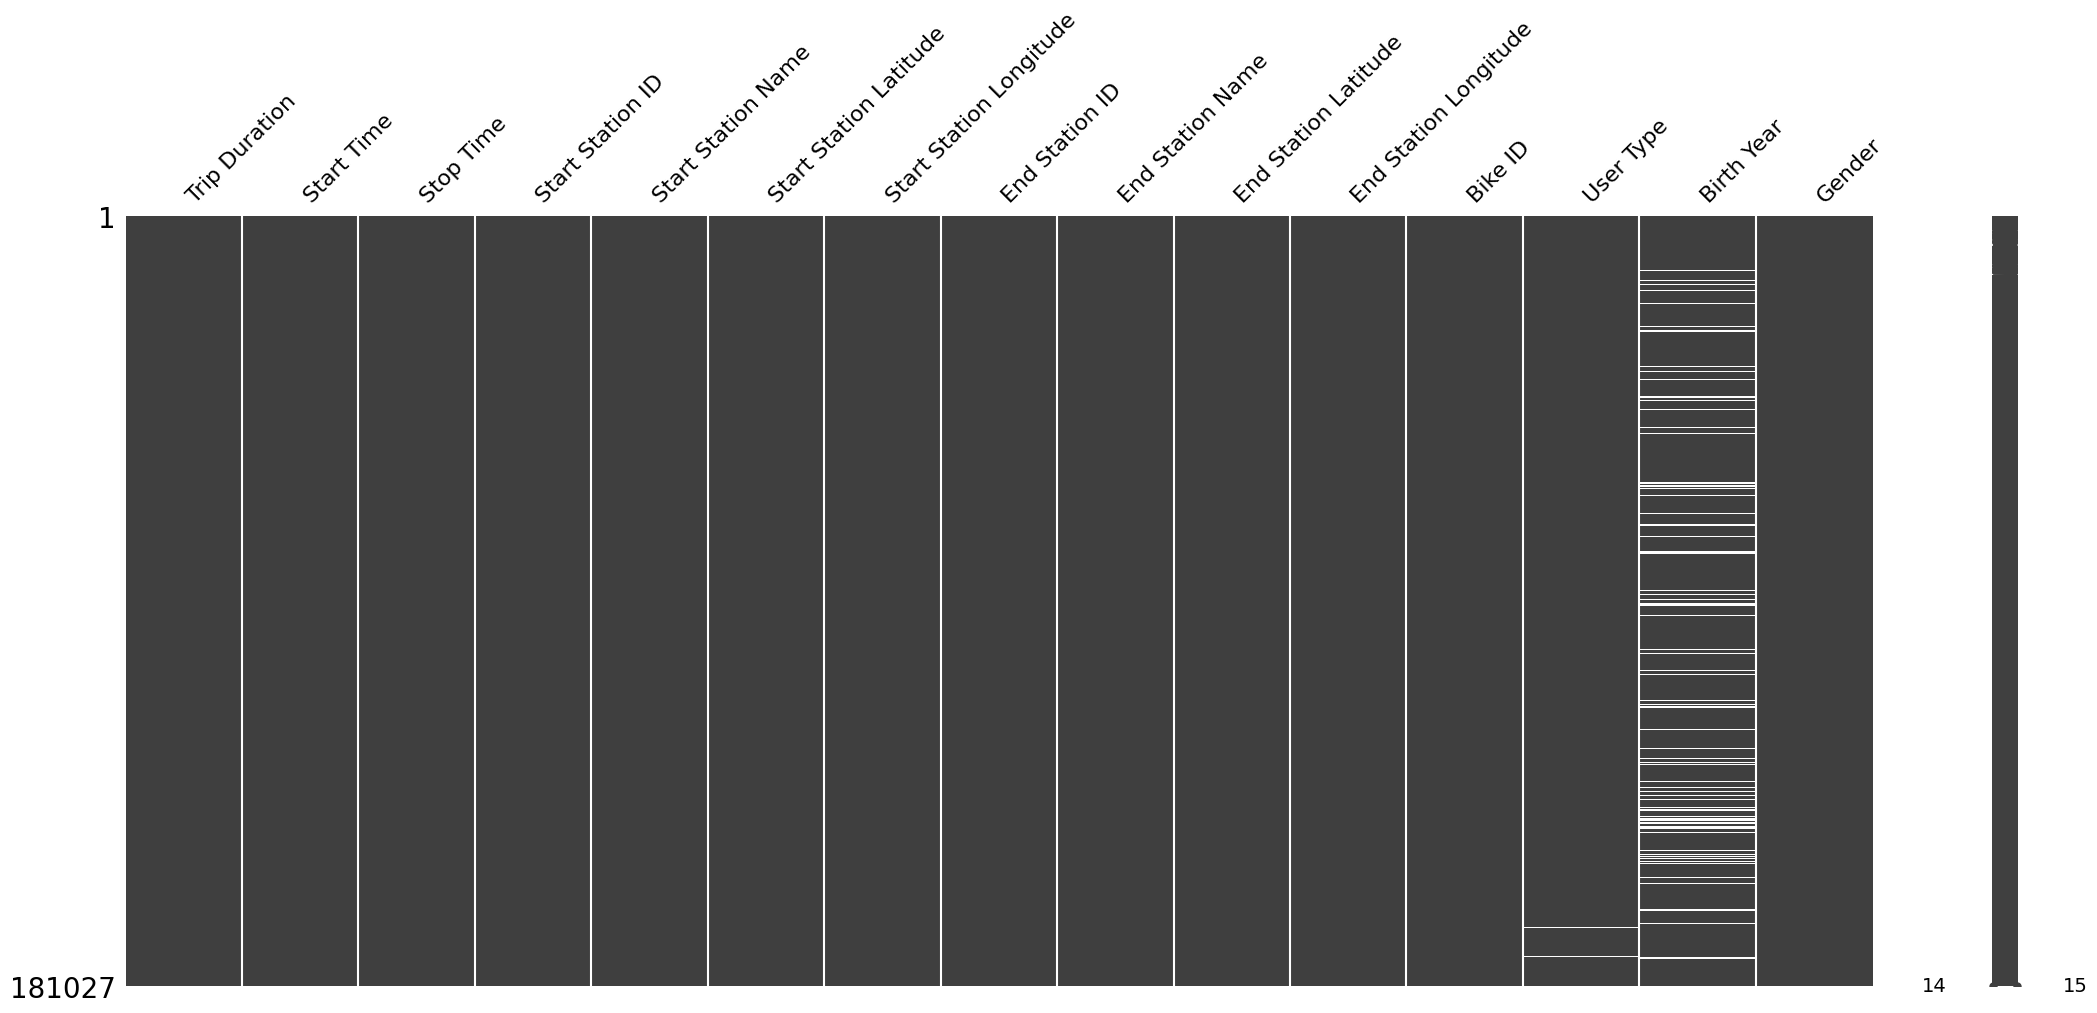

In [4]:
# Replace any blank rows with null values for imputation, this only works for this dataframe
trips.replace([''], np.NaN, inplace=True)

msno.matrix(trips)

In [5]:
trips.isnull().sum()

Trip Duration                  0
Start Time                     0
Stop Time                      0
Start Station ID               0
Start Station Name             0
Start Station Latitude         0
Start Station Longitude        0
End Station ID                 0
End Station Name               0
End Station Latitude           0
End Station Longitude          0
Bike ID                        0
User Type                    240
Birth Year                 15440
Gender                         0
dtype: int64

In [6]:
trips['Birth Year'] = trips['Birth Year'].fillna(trips['Birth Year'].mean())
trips['User Type'].replace([np.nan], np.random.choice(['Subscriber', 'Customer']), inplace=True)
trips.isnull().sum()

Trip Duration              0
Start Time                 0
Stop Time                  0
Start Station ID           0
Start Station Name         0
Start Station Latitude     0
Start Station Longitude    0
End Station ID             0
End Station Name           0
End Station Latitude       0
End Station Longitude      0
Bike ID                    0
User Type                  0
Birth Year                 0
Gender                     0
dtype: int64

In [7]:
duplicates = trips.duplicated()
print(duplicates.value_counts())

False    181027
Name: count, dtype: int64


#### NOAA

<Axes: >

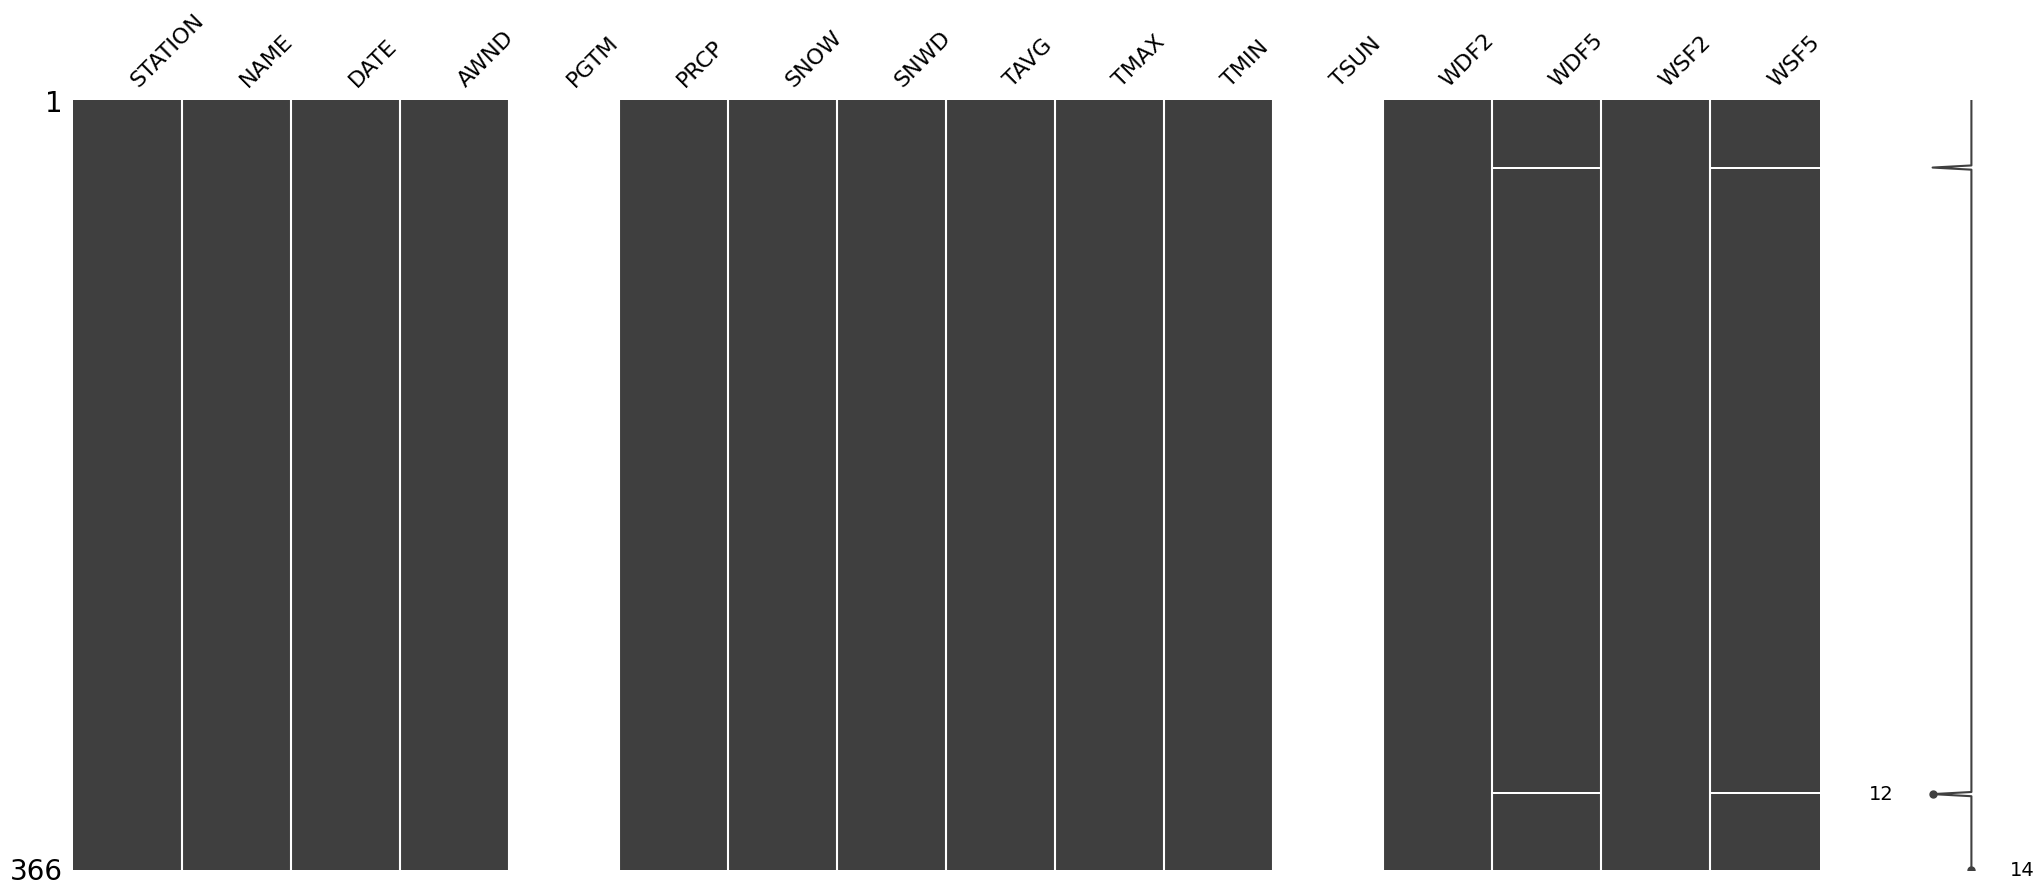

In [8]:
NOAA.replace([''], np.NaN, inplace=True)

msno.matrix(NOAA)

In [9]:
print(NOAA.shape)
NOAA.isnull().sum()

(366, 16)


STATION      0
NAME         0
DATE         0
AWND         0
PGTM       366
PRCP         0
SNOW         0
SNWD         0
TAVG         0
TMAX         0
TMIN         0
TSUN       366
WDF2         0
WDF5         2
WSF2         0
WSF5         2
dtype: int64

In [10]:
NOAA.drop(columns=['PGTM', 'TSUN'], inplace=True)
NOAA['WDF5'] = NOAA['WDF5'].fillna(NOAA['WDF5'].mean())
NOAA['WSF5'] = NOAA['WSF5'].fillna(NOAA['WDF5'].mean())
NOAA.isnull().sum()

STATION    0
NAME       0
DATE       0
AWND       0
PRCP       0
SNOW       0
SNWD       0
TAVG       0
TMAX       0
TMIN       0
WDF2       0
WDF5       0
WSF2       0
WSF5       0
dtype: int64

## Data Wrangling

#### Trips

In [11]:
trips.columns = trips.columns.str.lower().str.replace(' ', '_')

# Rename the trip_duration column to add sec to it in order to provide more clarity that it is in seconds and not in minutes
trips.rename(columns={'trip_duration': 'trip_duration_sec'}, inplace=True)

In [12]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181027 entries, 0 to 33424
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   trip_duration_sec        181027 non-null  int64  
 1   start_time               181027 non-null  object 
 2   stop_time                181027 non-null  object 
 3   start_station_id         181027 non-null  int64  
 4   start_station_name       181027 non-null  object 
 5   start_station_latitude   181027 non-null  float64
 6   start_station_longitude  181027 non-null  float64
 7   end_station_id           181027 non-null  int64  
 8   end_station_name         181027 non-null  object 
 9   end_station_latitude     181027 non-null  float64
 10  end_station_longitude    181027 non-null  float64
 11  bike_id                  181027 non-null  int64  
 12  user_type                181027 non-null  object 
 13  birth_year               181027 non-null  float64
 14  gender    

In [13]:
# Convert time features to proper data types
trips['start_time'] = pd.to_datetime(trips['start_time'])
trips['stop_time'] = pd.to_datetime(trips['stop_time'])
trips['birth_year'] = trips['birth_year'].astype(int)
trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181027 entries, 0 to 33424
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   trip_duration_sec        181027 non-null  int64         
 1   start_time               181027 non-null  datetime64[ns]
 2   stop_time                181027 non-null  datetime64[ns]
 3   start_station_id         181027 non-null  int64         
 4   start_station_name       181027 non-null  object        
 5   start_station_latitude   181027 non-null  float64       
 6   start_station_longitude  181027 non-null  float64       
 7   end_station_id           181027 non-null  int64         
 8   end_station_name         181027 non-null  object        
 9   end_station_latitude     181027 non-null  float64       
 10  end_station_longitude    181027 non-null  float64       
 11  bike_id                  181027 non-null  int64         
 12  user_type             

In [14]:
trips.head()

,trip_duration_sec,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964,2
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984,1
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,1979,0


In [15]:
# Most popular starting stations
print(trips.groupby("start_station_name").size().sort_values(ascending=False))

start_station_name
Grove St PATH            20761
Exchange Place           14442
Sip Ave                  12999
Hamilton Park            11326
Newport PATH             10768
Brunswick St              7700
Essex Light Rail          7648
Newport Pkwy              7379
Newark Ave                6932
Van Vorst Park            6593
Warren St                 6385
Paulus Hook               6150
City Hall                 5841
McGinley Square           5385
Liberty Light Rail        5330
JC Medical Center         3626
Baldwin at Montgomery     3596
Morris Canal              2995
Oakland Ave               2874
Pershing Field            2705
Lincoln Park              2629
Marin Light Rail          2182
5 Corners Library         2098
Hilltop                   1987
Christ Hospital           1930
Jersey & 6th St           1811
Central Ave               1803
Dey St                    1726
Jersey & 3rd              1672
Monmouth and 6th          1604
Riverview Park            1405
Heights Elevator    

#### NOAA

In [16]:
print(NOAA.STATION.unique())
print(NOAA.NAME.unique())

['USW00014734']
['NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US']


In [17]:
NOAA.drop(columns=['STATION', 'NAME'], inplace=True)

NOAA.rename(columns={
    'DATE': 'date',
    'AWND': 'avg_wind', 
    'PRCP': 'precipitation', 
    'SNOW': 'snow', 
    'SNWD': 'snow_depth', 
    'TAVG': 'avg_temp', 
    'TMAX': 'max_temp', 
    'TMIN': 'min_temp', 
    'WDF2': 'top_wind_dir_2_min', 
    'WDF5': 'top_wind_dir_5_min', 
    'WSF2': 'top_wind_speed_2_min',
    'WSF5': 'top_wind_speed_5_min',  
}, inplace = True)

In [18]:
NOAA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  366 non-null    object 
 1   avg_wind              366 non-null    float64
 2   precipitation         366 non-null    float64
 3   snow                  366 non-null    float64
 4   snow_depth            366 non-null    float64
 5   avg_temp              366 non-null    int64  
 6   max_temp              366 non-null    int64  
 7   min_temp              366 non-null    int64  
 8   top_wind_dir_2_min    366 non-null    int64  
 9   top_wind_dir_5_min    366 non-null    float64
 10  top_wind_speed_2_min  366 non-null    float64
 11  top_wind_speed_5_min  366 non-null    float64
dtypes: float64(7), int64(4), object(1)
memory usage: 34.4+ KB


In [19]:
NOAA['date'] = pd.to_datetime(NOAA['date'])

In [20]:
NOAA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  366 non-null    datetime64[ns]
 1   avg_wind              366 non-null    float64       
 2   precipitation         366 non-null    float64       
 3   snow                  366 non-null    float64       
 4   snow_depth            366 non-null    float64       
 5   avg_temp              366 non-null    int64         
 6   max_temp              366 non-null    int64         
 7   min_temp              366 non-null    int64         
 8   top_wind_dir_2_min    366 non-null    int64         
 9   top_wind_dir_5_min    366 non-null    float64       
 10  top_wind_speed_2_min  366 non-null    float64       
 11  top_wind_speed_5_min  366 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 34.4 KB


In [21]:
NOAA.head()

,date,avg_wind,precipitation,snow,snow_depth,avg_temp,max_temp,min_temp,top_wind_dir_2_min,top_wind_dir_5_min,top_wind_speed_2_min,top_wind_speed_5_min
0,2016-01-01,12.75,0.0,0.0,0.0,41,43,34,270,280.0,25.9,35.1
1,2016-01-02,9.40,0.0,0.0,0.0,36,42,30,260,260.0,21.0,25.1
2,2016-01-03,10.29,0.0,0.0,0.0,37,47,28,270,250.0,23.9,30.0
3,2016-01-04,17.22,0.0,0.0,0.0,32,35,14,330,330.0,25.9,33.1
4,2016-01-05,9.84,0.0,0.0,0.0,19,31,10,360,350.0,25.1,31.1


In [22]:
NOAA.to_csv('NOAA.csv', index=False)
trips.to_csv('trips.csv', index=False)